## Correcting for "glint"

Some CHEOPS data sets are affected by _glint_ - artefacts caused by scattered light that is not removed by the data reduction pipeline. These are thought to be caused by internal reflections within the telescope structure, e.g., moonlight reflected from the secondary mirror vanes.

To account for glint we can construct a smooth function as a function of the spacecraft roll angle. This can be constructed from the data outside the eclipse or by fitting the residuals from an initial fit to the data. In this notebook we fit the out-of-eclipse data.

This notebook demonstrates the correction for glint within `pycheops`  by injecting a simulated glint artefact into a simulated dataset. 

In [1]:
%pylab inline
from pycheops import Dataset
from uncertainties import ufloat
from pycheops.constants import R_SunN, c

Populating the interactive namespace from numpy and matplotlib


### Load  dataset
Using the same CHEOPSim simulated dataset as `dataset_fit_eclipse_from_simulation`.

In [2]:
#dataset=Dataset.from_test_data('DP-080', target='EBLM J0113+31')
dataset = Dataset('CH_PR900048_TG001701_V0000', target='EBLM J0113+31')
_  = dataset.get_lightcurve(aperture='OPTIMAL')

time, flux, flux_err = dataset.clip_outliers(verbose=True)

Found archive tgzfile /Users/pflm/pycheops_data/CH_PR900048_TG001701_V0000.tgz
 PI name     : CHEOPSim
 OBS ID      : 7798
 Target      : EBLM J0113+31
 Coordinates : 01:13:51.33 +31:49:10.1
 Spec. type  : G0
 V magnitude : 10.06 +- 0.00
Light curve data loaded from  /Users/pflm/pycheops_data/CH_PR900048_TG001701_V0000-OPTIMAL.fits
Time stored relative to BJD = 2459128
Aperture radius used = 30 arcsec
Mean counts = 10091662.8
Median counts = 10091105.2
RMS counts = 5478.1 [543 ppm]
Median standard error = 3261.6 [323 ppm]

Rejected 6 points more than 5.0 x MAD = 1387 ppm from the median


### Least-squares fit

 

In [3]:
BJD_0 = 2456023.26988
P = 14.2769001
E = round((dataset.bjd_ref-BJD_0)/P)
T_0 = ufloat(BJD_0 + P*E - dataset.bjd_ref,0.0002)
D = 0.02300
W = 0.01890391
b = 0.299
f_c = 0.08707092 
f_s = -0.54974417 
a_c = 25.808*R_SunN/c/86400  # Light travel time across the orbit in days

result = dataset.lmfit_eclipse(T_0=T_0, P=P, D=D, W=W, b=b, L=(0.0001,0.1),
                               f_c=f_c, f_s=f_s, a_c= a_c) 
print(dataset.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 983
    # variables        = 3
    chi-square         = 2478.90780
    reduced chi-square = 2.52949776
    Akaike info crit   = 915.239827
    Bayesian info crit = 929.911655
    RMS residual       = 513.7 ppm
[[Variables]]
    T_0: -6.64287267 +/- 3.1781e-04 (0.00%) (init = -6.642798)
    P:    14.2769 (fixed)
    D:    0.023 (fixed)
    W:    0.01890391 (fixed)
    b:    0.299 (fixed)
    L:    2.0589e-04 +/- 3.8842e-05 (18.87%) (init = 0.05005)
    f_c:  0.08707092 (fixed)
    f_s: -0.5497442 (fixed)
    c:    1.00009799 +/- 1.9149e-05 (0.00%) (init = 1)
    a_c:  0.0006931734 (fixed)
    k:    0.15165751 +/- 0.00000000 (0.00%) == 'sqrt(D)'
    aR:   18.7270014 +/- 0.00000000 (0.00%) == 'sqrt((1+k)**2-b**2)/W/pi'
    e:    0.30980000 +/- 0.00000000 (0.00%) == 'f_c**2 + f_s**2'
[[Correlations]] (unreported correlations are < 0.100)
    C(L, c) =  0.515
[[Priors]]
    T_0:-6.642798

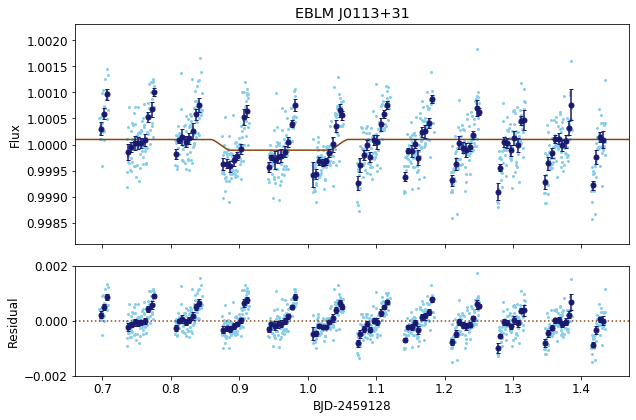

In [4]:
fig = dataset.plot_lmfit(title=dataset.target,figsize=(9,6),fontsize=12,binwidth=0.005)


### Injection of a simulated glint artefact

Glint artefacts tend to show a peak with a dip either side caused by the scattered light perturbing the background flux estimate. Approximate this with a sinc function.

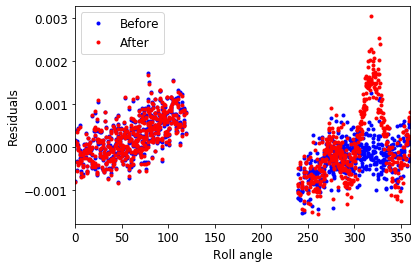

In [5]:
A_glint = 180 ## Amplitude of glint artefact in ppm
angle = np.array(dataset.lc['roll_angle'])
flux = np.array(dataset.lc['flux'])
fit = dataset.lmfit.bestfit
res = flux - fit
plt.plot(angle,res,'b.',label='Before')

phi = (angle-320)*np.pi/180
gfunc = A_glint*1e-6*sin(10*phi)/phi
flux = flux + gfunc
res = flux - fit
plt.plot(angle,res,'r.',label='After')
plt.xlabel('Roll angle')
plt.ylabel('Residuals')
plt.legend()
plt.xlim(0,360)
dataset.lc['flux'] = flux

### Fit to out-of-eclipse data


#### First create a mask file to exclude the eclipse from the fit
Mask position estimated by-eye from the plot of the fit to the eclipse above.

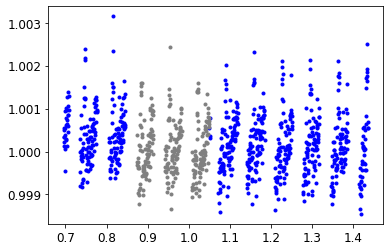

In [6]:
mask = (time > 0.85) & (time < 1.05)
plot(time[~mask],flux[~mask],'o',c='blue',ms=3)
plot(time[mask],flux[mask],'o',c='gray',ms=3)

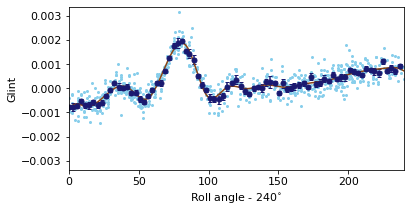

In [7]:
glint = dataset.add_glint(16, binwidth=3, fit_flux=True, mask=mask)

In [8]:
result = dataset.lmfit_eclipse(T_0=T_0, P=P, D=D, W=W, b=b, L=(0.0001,0.1),
                               f_c=f_c, f_s=f_s, a_c= a_c, 
                               dfdsinphi=(-1,1), dfdcosphi=(-1,1), glint_scale=(0,2)) 
print(dataset.lmfit_report())


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 983
    # variables        = 6
    chi-square         = 1168.12755
    reduced chi-square = 1.19562697
    Akaike info crit   = 181.614921
    Bayesian info crit = 210.958576
    RMS residual       = 352.6 ppm
[[Variables]]
    T_0:         -6.64280470 +/- 2.1831e-04 (0.00%) (init = -6.642798)
    P:            14.2769 (fixed)
    D:            0.023 (fixed)
    W:            0.01890391 (fixed)
    b:            0.299 (fixed)
    L:            3.0362e-04 +/- 2.6947e-05 (8.88%) (init = 0.05005)
    f_c:          0.08707092 (fixed)
    f_s:         -0.5497442 (fixed)
    c:            1.00000564 +/- 1.6832e-05 (0.00%) (init = 1)
    a_c:          0.0006931734 (fixed)
    dfdsinphi:    6.1041e-06 +/- 1.4946e-05 (244.85%) (init = 0)
    dfdcosphi:   -1.2418e-05 +/- 2.6099e-05 (210.17%) (init = 0)
    glint_scale:  0.99713874 +/- 0.02084336 (2.09%) (init = 1)
    k:            0.15165751

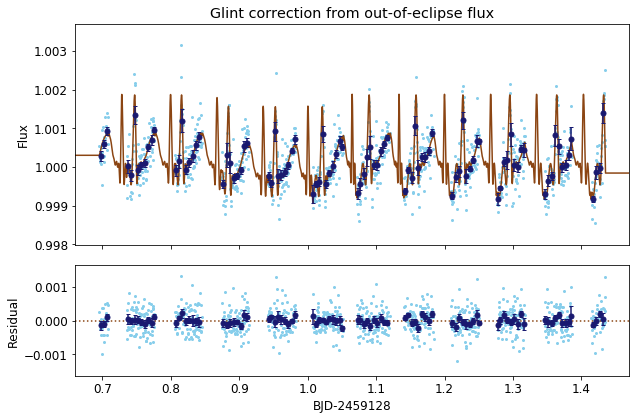

In [9]:
fig = dataset.plot_lmfit(title='Glint correction from out-of-eclipse flux',
                         figsize=(9,6),fontsize=12,binwidth=0.005)

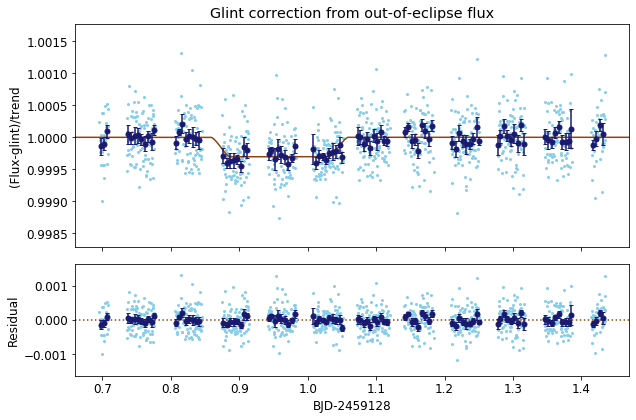

In [10]:
fig = dataset.plot_lmfit(title='Glint correction from out-of-eclipse flux',
                         figsize=(9,6),fontsize=12,binwidth=0.005,detrend=True)


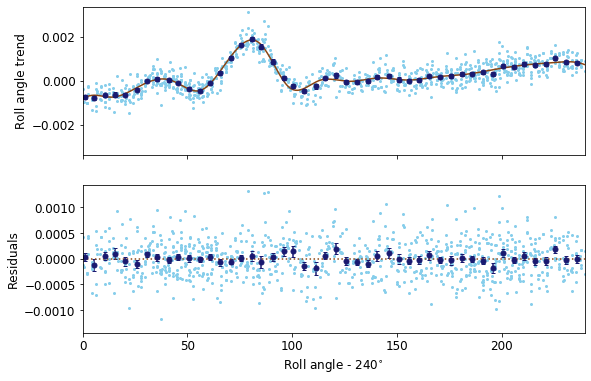

In [11]:
fig = dataset.rollangle_plot(figsize=(9,6),fontsize=12,binwidth=5)

In [12]:
result = dataset.lmfit_eclipse(T_0=T_0, P=P, D=D, W=W, b=b, L=(0.0001,0.1),
                               f_c=f_c, f_s=f_s, a_c= a_c, 
                               dfdsinphi=(-1,1), dfdcosphi=(-1,1), glint_scale=(0,2)) 
print(dataset.lmfit_report())


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 983
    # variables        = 6
    chi-square         = 1168.12755
    reduced chi-square = 1.19562697
    Akaike info crit   = 181.614921
    Bayesian info crit = 210.958576
    RMS residual       = 352.6 ppm
[[Variables]]
    T_0:         -6.64280470 +/- 2.1831e-04 (0.00%) (init = -6.642798)
    P:            14.2769 (fixed)
    D:            0.023 (fixed)
    W:            0.01890391 (fixed)
    b:            0.299 (fixed)
    L:            3.0362e-04 +/- 2.6947e-05 (8.88%) (init = 0.05005)
    f_c:          0.08707092 (fixed)
    f_s:         -0.5497442 (fixed)
    c:            1.00000564 +/- 1.6832e-05 (0.00%) (init = 1)
    a_c:          0.0006931734 (fixed)
    dfdsinphi:    6.1041e-06 +/- 1.4946e-05 (244.85%) (init = 0)
    dfdcosphi:   -1.2418e-05 +/- 2.6099e-05 (210.17%) (init = 0)
    glint_scale:  0.99713874 +/- 0.02084336 (2.09%) (init = 1)
    k:            0.15165751

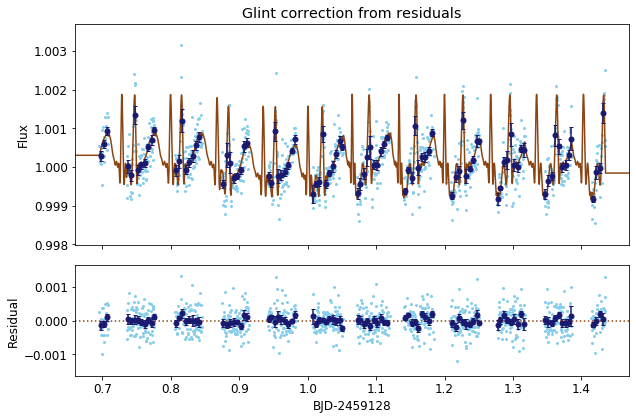

In [13]:
fig = dataset.plot_lmfit(title='Glint correction from residuals',
                         figsize=(9,6),fontsize=12,binwidth=0.005)

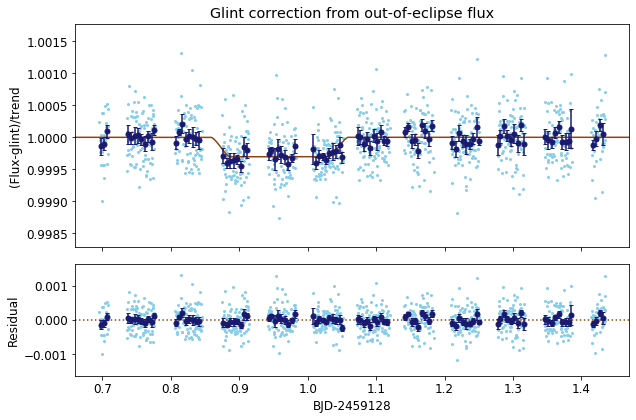

In [14]:
fig = dataset.plot_lmfit(title='Glint correction from out-of-eclipse flux',
                         figsize=(9,6),fontsize=12,binwidth=0.005,detrend=True)


### Sampling the posterior
Sampling the posterior probability distribution using the affine-invariant sampler [emcee](https://emcee.readthedocs.io/en/stable/). 

The $\pm$1-sigma limits on parameters from the prior are indicated in the corner plot using dashed lines.

This return value from emcee_transit is an instance of an [EnsembleSampler](https://emcee.readthedocs.io/en/latest/user/sampler/) object.

In [15]:
sampler = dataset.emcee_sampler()
print(dataset.emcee_report(min_correl=0.5))

Running burn-in ..


100%|██████████| 256/256 [02:08<00:00,  2.00it/s]

Running sampler ..



100%|██████████| 512/512 [03:06<00:00,  2.75it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 32768
    # data points      = 982
    # variables        = 7
    chi-square         = 1168.44161
    reduced chi-square = 1.19840165
    Akaike info crit   = -12821.1587
    Bayesian info crit = -12786.9315
    RMS residual       = 352.6 ppm
[[Variables]]
    T_0:         -6.64280354 +/- 2.0112e-04 (0.00%) (init = -6.642798)
    P:            14.2769 (fixed)
    D:            0.023 (fixed)
    W:            0.01890391 (fixed)
    b:            0.299 (fixed)
    L:            3.0143e-04 +/- 2.6483e-05 (8.79%) (init = 0.05005)
    f_c:          0.08707092 (fixed)
    f_s:         -0.5497442 (fixed)
    c:            1.00000565 +/- 1.6495e-05 (0.00%) (init = 1)
    a_c:          0.0006931734 (fixed)
    dfdsinphi:    4.7232e-06 +/- 1.4339e-05 (303.59%) (init = 0)
    dfdcosphi:   -1.2032e-05 +/- 2.5977e-05 (215.91%) (init = 0)
    glint_scale:  0.99573197 +/- 0.02040638 (2.05%) (init = 1)
    k:            0.15165

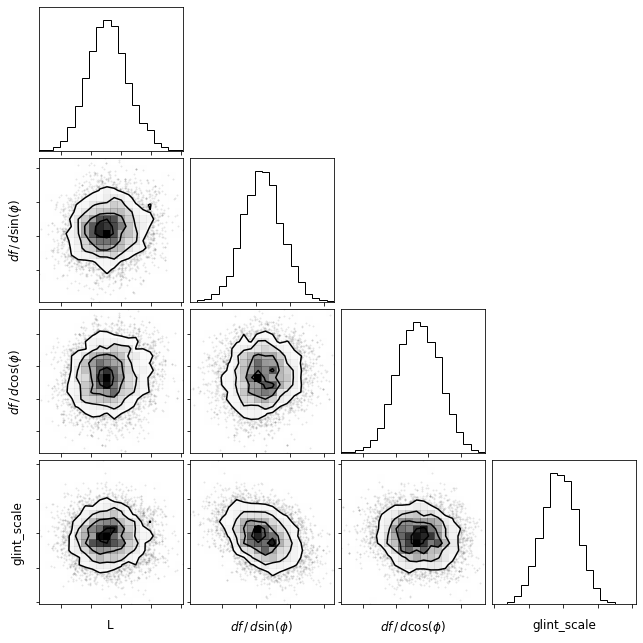

In [16]:
cornerplot = dataset.corner_plot(['L','dfdsinphi','dfdcosphi','glint_scale'])

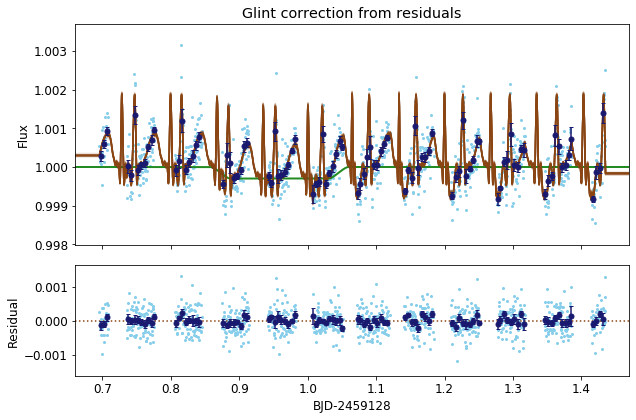

In [17]:
fig = dataset.plot_emcee(title='Glint correction from residuals',
                         figsize=(9,6),fontsize=12, binwidth=0.005)

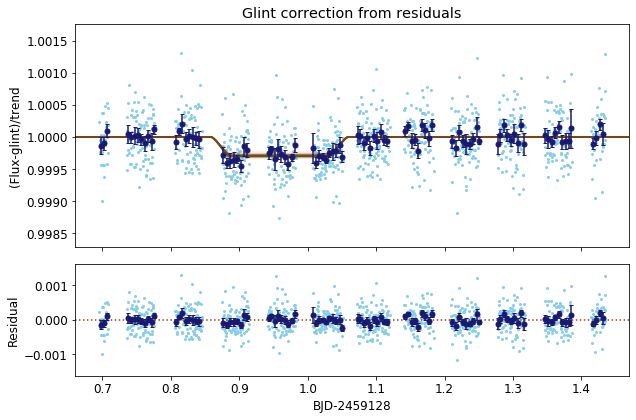

In [18]:
fig = dataset.plot_emcee(title='Glint correction from residuals', detrend=True,
                         figsize=(9,6),fontsize=12, binwidth=0.005)

### Add correlated noise

Now use "add_shoterm=True" so that correlated noise is modelled using the SHOTerm kernel from [celerite](https://celerite.readthedocs.io/en/stable/).

Broad priors on log_sigma, log_omega0 and log_S0 from a previous run of this sampler without priors are used here to remove long tails in the distrubtions with very few samples  that mess up the plots.

In [19]:
sampler = dataset.emcee_sampler(add_shoterm=True,  
                                log_sigma=(-11,-7), log_omega0=(3.5,7.5), log_S0=(-30,-20))
print(dataset.emcee_report())

Running burn-in ..


100%|██████████| 256/256 [01:19<00:00,  3.23it/s]

Running sampler ..



100%|██████████| 512/512 [03:02<00:00,  2.80it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 32768
    # data points      = 982
    # variables        = 9
    chi-square         = 1168.35122
    reduced chi-square = 1.20077207
    Akaike info crit   = -12817.1452
    Bayesian info crit = -12773.1389
    RMS residual       = 352.6 ppm
[[Variables]]
    T_0:         -6.64277672 +/- 2.0201e-04 (0.00%) (init = -6.642798)
    P:            14.2769 (fixed)
    D:            0.023 (fixed)
    W:            0.01890391 (fixed)
    b:            0.299 (fixed)
    L:            3.0575e-04 +/- 2.7063e-05 (8.85%) (init = 0.05005)
    f_c:          0.08707092 (fixed)
    f_s:         -0.5497442 (fixed)
    c:            1.00000624 +/- 1.7974e-05 (0.00%) (init = 1)
    a_c:          0.0006931734 (fixed)
    dfdsinphi:    4.7052e-06 +/- 1.5525e-05 (329.96%) (init = 0)
    dfdcosphi:   -1.3262e-05 +/- 2.6371e-05 (198.85%) (init = 0)
    glint_scale:  0.99661080 +/- 0.01995783 (2.00%) (init = 1)
    k:            0.15165

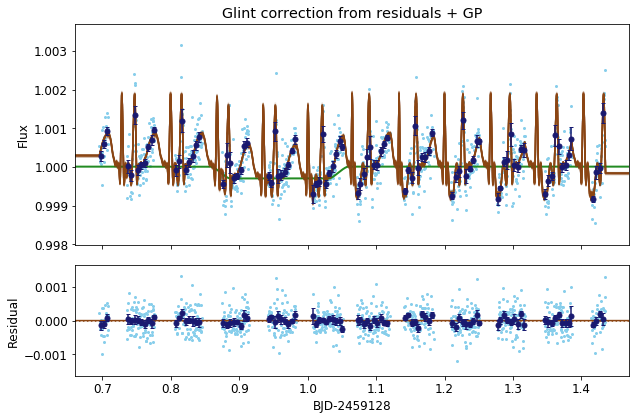

In [20]:
fig = dataset.plot_emcee(title='Glint correction from residuals + GP',
                         figsize=(9,6),fontsize=12, binwidth=0.005)

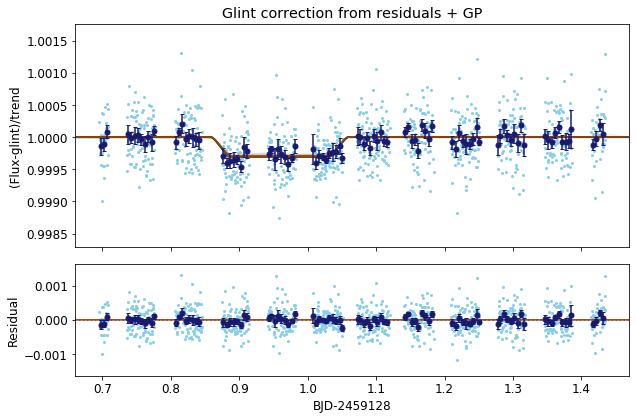

In [21]:
fig = dataset.plot_emcee(title='Glint correction from residuals + GP', detrend=True,
                         figsize=(9,6),fontsize=12, binwidth=0.005,)

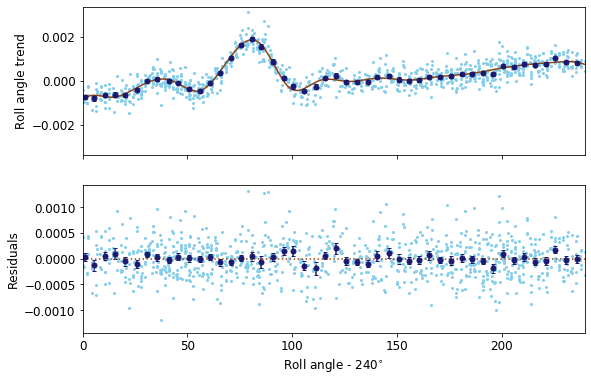

In [22]:
fig = dataset.rollangle_plot(figsize=(9,6),fontsize=12,binwidth=5)

&copy; Pierre Maxted, Keele University 2020